In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from copulas.multivariate import GaussianMultivariate
import numpy as np
from itertools import combinations
import importlib
import logging
import itertools
import ast
#import seaborn as sns


In [3]:
Data_folder = os.getcwd() + "/Data"

Data_folder

'/home/trapfishscott/Cambridge24.25/Energy_thesis/Data'

In [4]:
## Import pickls

car_df = pd.read_pickle(Data_folder + "/df_car.pkl")

In [5]:
# Trip type by travel day by journey sequence
x = car_df.groupby(["IndividualID", "TravDay", "JourSeq"])[["TripType"]].first()
x.head()
# Trip type by travel day by journey sequence
x = x.groupby(["IndividualID", "TravDay"])[["TripType"]].agg(list)

x = x.reset_index()

In [6]:
x["SumTrips"] = x["TripType"].apply(lambda x: len(x))

In [7]:
days = np.tile(np.arange(1,8), len(x["IndividualID"].unique()))

individuals = [i for i in x["IndividualID"].unique() for _ in range(7)]

new_df = pd.DataFrame({"IndividualID": individuals,
                       "TravDay": days })

merged_df = new_df.merge(x, on=["IndividualID", "TravDay"], how="left")

merged_df = merged_df.fillna(0)

merged_df["TripType"] = merged_df["TripType"].apply(lambda x: str(x))


In [8]:


print(f"There are {len(merged_df["TripType"].unique())} unique trip sequences.")


There are 5921 unique trip sequences.


In [9]:
merged_df

,IndividualID,TravDay,TripType,SumTrips
0,2002000001,1,0,0.0
1,2002000001,2,0,0.0
2,2002000001,3,0,0.0
3,2002000001,4,0,0.0
4,2002000001,5,0,0.0
...,...,...,...,...
1211583,2023017379,3,"[(3, 1), (1, 3), (3, 2), (2, 3)]",4.0
1211584,2023017379,4,"[(3, 2), (2, 3)]",2.0
1211585,2023017379,5,0,0.0
1211586,2023017379,6,"[(3, 1), (1, 3)]",2.0


In [10]:
# Finding if 1 trip, 2 trips, 3 trips ... per day. How many unique trip sequences in total + probabilities for different kinds of trip sequences

trip_probs = merged_df[["SumTrips", "TripType"]].groupby("SumTrips").value_counts(normalize=True).reset_index()

In [11]:
trip_probs["TripType"] = trip_probs["TripType"].apply(ast.literal_eval)

In [12]:
trip_probs

,SumTrips,TripType,proportion
0,0.0,0,1.000000
1,1.0,"[(3, 2)]",0.359880
2,1.0,"[(2, 3)]",0.358808
3,1.0,"[(3, 1)]",0.137585
4,1.0,"[(1, 3)]",0.094877
...,...,...,...
5916,20.0,"[(3, 2), (2, 3), (3, 2), (2, 2), (2, 3), (3, 2...",0.333333
5917,21.0,"[(3, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2...",0.333333
5918,21.0,"[(3, 2), (2, 2), (2, 2), (2, 2), (2, 3), (3, 2...",0.333333
5919,21.0,"[(3, 2), (2, 3), (3, 2), (2, 2), (2, 2), (2, 3...",0.333333


In [13]:
pop_seq_weights = {}

for trip_length in trip_probs.SumTrips.unique():
    by_trip_length = trip_probs[trip_probs["SumTrips"] == trip_length]
    print(by_trip_length.head())
    population = list(by_trip_length["TripType"])
    weights = list(by_trip_length["proportion"])
    #print(population[0])
    #print(weights[0])
    pop_seq_weights[f"trip_length_{int(trip_length)}"] = [population, weights]



   SumTrips TripType  proportion
0       0.0        0         1.0
   SumTrips  TripType  proportion
1       1.0  [(3, 2)]    0.359880
2       1.0  [(2, 3)]    0.358808
3       1.0  [(3, 1)]    0.137585
4       1.0  [(1, 3)]    0.094877
5       1.0  [(2, 2)]    0.043675
    SumTrips          TripType  proportion
8        2.0  [(3, 2), (2, 3)]    0.583721
9        2.0  [(3, 1), (1, 3)]    0.357063
10       2.0  [(2, 2), (2, 2)]    0.013905
11       2.0  [(1, 3), (3, 1)]    0.013148
12       2.0  [(2, 2), (2, 3)]    0.007467
    SumTrips                  TripType  proportion
50       3.0  [(3, 2), (2, 2), (2, 3)]    0.452526
51       3.0  [(3, 1), (1, 2), (2, 3)]    0.208922
52       3.0  [(3, 2), (2, 1), (1, 3)]    0.091577
53       3.0  [(3, 2), (2, 3), (3, 2)]    0.040018
54       3.0  [(2, 3), (3, 2), (2, 3)]    0.037630
     SumTrips                          TripType  proportion
206       4.0  [(3, 2), (2, 3), (3, 2), (2, 3)]    0.480470
207       4.0  [(3, 1), (1, 3), (3, 2), (2, 3)

In [14]:
pop_seq_weights["trip_length_2"][1]

[0.5837208681750808,
 0.35706332282925907,
 0.013905162522045213,
 0.0131482869625759,
 0.007466868500149192,
 0.00654745876605025,
 0.004451495678289073,
 0.0030056692890464095,
 0.0021978501823051227,
 0.002040167774082349,
 0.001855800650621875,
 0.0009533720989469241,
 0.0009048544348783784,
 0.0006113225672636765,
 0.0005167131223300122,
 0.00038814131254836604,
 0.00026684715237700166,
 0.00026442126917357436,
 0.00020134830588446488,
 5.579531367882762e-05,
 4.8517664068545755e-05,
 4.8517664068545755e-05,
 4.366589766169118e-05,
 3.638824805140932e-05,
 3.396236484798203e-05,
 3.153648164455474e-05,
 2.9110598441127454e-05,
 2.6684715237700166e-05,
 2.4258832034272877e-05,
 1.9407065627418304e-05,
 1.9407065627418304e-05,
 9.703532813709152e-06,
 9.703532813709152e-06,
 9.703532813709152e-06,
 9.703532813709152e-06,
 7.2776496102818635e-06,
 7.2776496102818635e-06,
 4.851766406854576e-06,
 4.851766406854576e-06,
 4.851766406854576e-06,
 2.425883203427288e-06,
 2.425883203427288

In [15]:
for i,(k,v) in enumerate(pop_seq_weights.items()):
    if i <=4:
        print(k, v[0][0], v[1][0])

trip_length_0 0 1.0
trip_length_1 [(3, 2)] 0.3598797699947726
trip_length_2 [(3, 2), (2, 3)] 0.5837208681750808
trip_length_3 [(3, 2), (2, 2), (2, 3)] 0.45252596816400226
trip_length_4 [(3, 2), (2, 3), (3, 2), (2, 3)] 0.4804698049806865


In [16]:
r = car_df["TripType"].value_counts(normalize=True).reset_index()

#1 work
#2 other
#3 home

mapping = {(2,3): "other->home",
           (3,2): "home->other",
           (3,1): "home->work",
           (2,2): "other->other",
           (1,3): "work->home",
           (1,2): "work->other",
           (2,1): "other->work"}

r["TripType_mapped"] = r["TripType"].map(mapping)

r

,TripType,proportion,TripType_mapped
0,"(2, 3)",0.324670,other->home
1,"(3, 2)",0.318645,home->other
2,"(3, 1)",0.106809,home->work
3,"(2, 2)",0.104834,other->other
4,"(1, 3)",0.099178,work->home
5,"(1, 2)",0.026362,work->other
6,"(2, 1)",0.019503,other->work


(array([1.5700e+02, 8.2000e+01, 4.3000e+01, 4.4000e+01, 4.9000e+01,
        7.2000e+01, 1.1700e+02, 3.2400e+02, 6.6800e+02, 1.9110e+03,
        4.5700e+03, 1.0510e+04, 2.5534e+04, 4.8286e+04, 4.3246e+04,
        3.6466e+04, 4.1277e+04, 3.4896e+04, 2.3870e+04, 2.4541e+04,
        1.9270e+04, 2.1533e+04, 2.3057e+04, 2.9038e+04, 2.7420e+04,
        2.0470e+04, 1.9116e+04, 1.7065e+04, 2.3434e+04, 2.1949e+04,
        2.8797e+04, 1.5818e+04, 9.8420e+03, 5.3600e+03, 3.0230e+03,
        1.9120e+03, 1.0180e+03, 6.2200e+02, 7.0000e+01, 7.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   0. ,   37.8,   75.6,  113.4,  151.2,  189. ,  226.8,  264.6,
         302.4,  340.2,  378. ,  415.8,  453.6,  491.4,  529.2,  567. ,
         604.8,  642.6,  680.4,  718.2,  756. ,  793.8,  831.6,  869.4,
         907.2,  945. ,  982.8, 1020.6, 1058.4, 1096.2, 1134. , 1171.8,
        1209.6, 1247.4, 1285.2

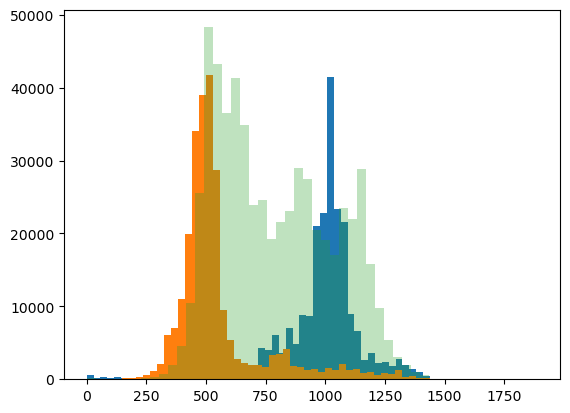

In [17]:
car_df_wd = car_df[car_df["TravelWeekDay_B03ID"]==1]


x = car_df_wd[car_df_wd["TripType"] == (1,3)]
y = car_df_wd[car_df_wd["TripType"] == (3,1)]
z = car_df_wd[car_df_wd["TripType"] == (3,2)]

plt.hist(x["TripStart"], bins=50)
plt.hist(y["TripEnd"], bins=50)
plt.hist(z["TripEnd"], bins=50, alpha=0.3)

(array([115632., 123554.,  89566.,  49463.,  39051.,  43039.,  19720.,
         11919.,  14888.,   7058.,  13756.,   5158.,   7190.,   3724.,
          2925.,   4598.,   3897.,   1525.,   1842.,   1366.,   3315.,
          1190.,    982.,    963.,    603.,   2132.,    754.,    564.,
           529.,   1054.,    901.,    600.,    321.,   1067.,    305.,
           731.,    311.,    718.,    281.,    285.,    513.,    693.,
           216.,    273.,    229.,    532.,    205.,    188.,    207.,
           634.]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ,
        13.2, 14.4, 15.6, 16.8, 18. , 19.2, 20.4, 21.6, 22.8, 24. , 25.2,
        26.4, 27.6, 28.8, 30. , 31.2, 32.4, 33.6, 34.8, 36. , 37.2, 38.4,
        39.6, 40.8, 42. , 43.2, 44.4, 45.6, 46.8, 48. , 49.2, 50.4, 51.6,
        52.8, 54. , 55.2, 56.4, 57.6, 58.8, 60. ]),
 <BarContainer object of 50 artists>)

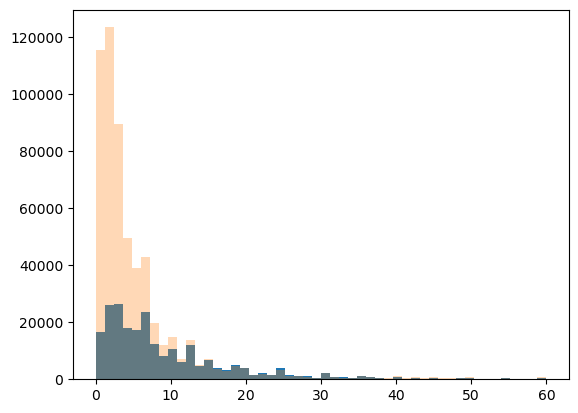

In [18]:
car_df_wd = car_df[car_df["TravelWeekDay_B03ID"]==1]


x = car_df_wd[car_df_wd["TripType"] == (1,3)]
y = car_df_wd[car_df_wd["TripType"] == (3,1)]
z = car_df_wd[car_df_wd["TripType"] == (3,2)]

plt.hist(x["TripDisExSW"], bins=50, range=(0,60))
#plt.hist(y["TripEnd"], bins=50)
plt.hist(z["TripDisExSW"], bins=50, alpha=0.3, range=(0,60))

(array([1.3700e+02, 7.6000e+01, 4.6000e+01, 4.9000e+01, 2.0000e+01,
        2.5000e+01, 2.9000e+01, 2.6000e+01, 3.9000e+01, 8.9000e+01,
        1.4900e+02, 3.9000e+02, 5.8000e+02, 1.5460e+03, 2.0700e+03,
        4.2040e+03, 5.5720e+03, 9.7400e+03, 1.3236e+04, 1.8131e+04,
        1.5806e+04, 1.6545e+04, 1.3494e+04, 1.2103e+04, 9.9450e+03,
        1.1091e+04, 9.5320e+03, 1.3701e+04, 8.4090e+03, 8.4630e+03,
        5.7610e+03, 6.5160e+03, 4.7550e+03, 4.8740e+03, 4.8450e+03,
        5.5560e+03, 5.6570e+03, 4.5910e+03, 3.4490e+03, 2.1780e+03,
        1.5220e+03, 8.9000e+02, 7.3100e+02, 4.7100e+02, 3.6000e+02,
        2.5400e+02, 6.4000e+01, 1.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([   0. ,   31.1,   62.2,   93.3,  124.4,  155.5,  186.6,  217.7,
         248.8,  279.9,  311. ,  342.1,  373.2,  404.3,  435.4,  466.5,
         497.6,  528.7,  559.8,  590.9,  622. ,  653.1,  684.2,  715.3,
         746.4,  777.5,  808.6,  839.7,  870.8,  901.9,  933. ,  964.1,
         995.2, 1026.3, 1057.4

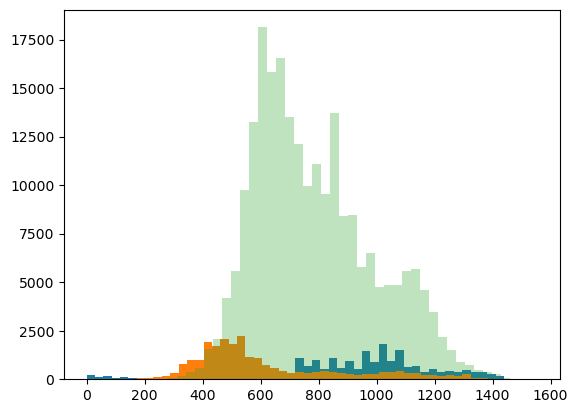

In [19]:
car_df_we = car_df[car_df["TravelWeekDay_B03ID"]==2]


x = car_df_we[car_df_we["TripType"] == (1,3)]
y = car_df_we[car_df_we["TripType"] == (3,1)]
z = car_df_we[car_df_we["TripType"] == (3,2)]

plt.hist(x["TripStart"], bins=50)
plt.hist(y["TripEnd"], bins=50)
plt.hist(z["TripEnd"], bins=50, alpha=0.3)